In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from CNN2D import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time
import os
import pickle

import pdb

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

torch.manual_seed(1)

## TRAIN SET

In [6]:
gt_train_coord = pickle.load( open( "./import_dataset_2/train/gt_train_coord.pkl", "rb" ) )
gt_train  = pickle.load( open( "./import_dataset_2/train/gt_train.pkl", "rb" ) )
in_train_coord  = pickle.load( open( "./import_dataset_2/train/in_train_coord.pkl", "rb" ) )
inputs_train = pickle.load( open( "./import_dataset_2/train/inputs_train.pkl", "rb" ) )

coord_ind = np.append(np.arange(0,2),np.arange(4,164))
inputs_train = inputs_train[:,:,coord_ind]
gt_train = gt_train[:,:,:2]

inputs_train = torch.from_numpy(inputs_train).float()
gt_train = torch.from_numpy(gt_train).float()

gt_train = gt_train.unsqueeze(1) # add 1 dimension to the training set
inputs_train = inputs_train.unsqueeze(1) # add 1 dimension to the training set

inputs_train.shape,gt_train.shape

(torch.Size([5157, 1, 10, 162]), torch.Size([5157, 1, 11, 2]))

## VALIDATION SET

In [7]:
gt_validation_coord = pickle.load( open( "./import_dataset_2/validation/gt_validation_coord.pkl", "rb" ) )
gt_validation = pickle.load( open( "./import_dataset_2/validation/gt_validation.pkl", "rb" ) )
in_validation_coord = pickle.load( open( "./import_dataset_2/validation/in_validation_coord.pkl", "rb" ) )
inputs_validation = pickle.load( open( "./import_dataset_2/validation/inputs_validation.pkl", "rb" ) )

coord_ind = np.append(np.arange(0,2),np.arange(4,164))
inputs_validation = inputs_validation[:,:,coord_ind]
gt_validation = gt_validation[:,:,:2]

inputs_validation = torch.from_numpy(inputs_validation).float()
gt_validation = torch.from_numpy(gt_validation).float()

gt_validation = gt_validation.unsqueeze(1) # add 1 dimension to the training set
inputs_validation = inputs_validation.unsqueeze(1) # add 1 dimension to the training set
print (inputs_validation.shape)

gt_validation_coord.shape,gt_validation.shape,in_validation_coord.shape,inputs_validation.shape

torch.Size([1719, 1, 10, 162])


((11, 1719, 2),
 torch.Size([1719, 1, 11, 2]),
 (10, 1719, 2),
 torch.Size([1719, 1, 10, 162]))

## TEST SET

In [4]:
gt_test_coord_1 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_1.pkl", "rb" ) )
gt_test_1 = pickle.load( open( "./import_dataset_2/test/gt_test_1.pkl", "rb" ) )
in_test_coord_1 = pickle.load( open( "./import_dataset_2/test/in_test_coord_1.pkl", "rb" ) )
inputs_test_1 = pickle.load( open( "./import_dataset_2/test/inputs_test_1.pkl", "rb" ) )

gt_test_coord_2 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_2.pkl", "rb" ) )
gt_test_2 = pickle.load( open( "./import_dataset_2/test/gt_test_2.pkl", "rb" ) )
in_test_coord_2 = pickle.load( open( "./import_dataset_2/test/in_test_coord_2.pkl", "rb" ) )
inputs_test_2 = pickle.load( open( "./import_dataset_2/test/inputs_test_2.pkl", "rb" ) )

gt_test_coord_3 = pickle.load( open( "./import_dataset_2/test/gt_test_coord_3.pkl", "rb" ) )
gt_test_3 = pickle.load( open( "./import_dataset_2/test/gt_test_3.pkl", "rb" ) )
in_test_coord_3 = pickle.load( open( "./import_dataset_2/test/in_test_coord_3.pkl", "rb" ) )
inputs_test_3 = pickle.load( open( "./import_dataset_2/test/inputs_test_3.pkl", "rb" ) )

inputs_test_1 = torch.from_numpy(inputs_test_1).float()
gt_test_1 = torch.from_numpy(gt_test_1).float()
inputs_test_1 = inputs_test_1.unsqueeze(1) 

inputs_test_2 = torch.from_numpy(inputs_test_2).float()
gt_test_2 = torch.from_numpy(gt_test_2).float()
inputs_test_2 = inputs_test_2.unsqueeze(1)

inputs_test_3 = torch.from_numpy(inputs_test_3).float()
gt_test_3 = torch.from_numpy(gt_test_3).float()
inputs_test_3 = inputs_test_3.unsqueeze(1)

torch.Size([10, 1, 460, 164])


### Model

In [11]:
net = CNN2D()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)

traindataset = utils.TensorDataset(inputs_train, gt_train[:,:,1:,:])
trainloader = utils.DataLoader(traindataset, batch_size=16, shuffle=True)

valdataset = utils.TensorDataset(inputs_validation, gt_validation[:,:,1:,:])
valloader = utils.DataLoader(valdataset, batch_size=16, shuffle=True)

In [12]:
epochs = 50
steps = 0
running_loss = 0
print_every = 323
loss_train = []
loss_val = []

for e in range(epochs):
    start = time.time()
    steps_bis = 0
    total_train_loss=0
    for train_coord, ground_tru in iter(trainloader):
        
        steps += 1
        steps_bis += 1
        
        input_train = Variable(train_coord)
        in_train = input_train.squeeze(1)
        target = Variable(ground_tru)
        targets = target.squeeze(1)
        optimizer.zero_grad()
        out = net.forward(input_train)
        out = out.reshape(out.shape[0],10,4)
        loss1 = (criterion(out[:,:,0:2], targets[:,:,0:2]))
        
        loss1.backward(retain_graph=True)
        optimizer.step()
        
        running_loss += (loss1).item()
        total_train_loss += (loss1).item()
        
        if steps % print_every == 0:
            stop = time.time()
            val_loss=0
            
            for ii, (images, labels) in enumerate(valloader):
                
                inp = Variable(images)
                input_val = inp.squeeze(1)
                lab = Variable(labels)
                valgt = lab.squeeze(1)
                predicted = net.predict(inp)
                predicted = predicted.reshape(predicted.shape[0],10,4)
                val_loss+= (criterion(predicted[:,:,0:2],valgt[:,:,0:2]).item())
                
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Validation Loss: {:.4f}..".format(val_loss/ii),
                  "Training Loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                 )
            loss_val.append(val_loss/ii)
            running_loss = 0
            start = time.time()
    loss_train.append(total_train_loss/steps_bis)

NameError: name 'F' is not defined

In [8]:
epochs = 50
steps = 0
running_loss = 0
print_every = 323
loss_train = []
loss_val = []

for e in range(epochs):
    start = time.time()
    steps_bis = 0
    total_train_loss=0
    for train_coord, ground_tru in iter(trainloader):
        
        steps += 1
        steps_bis += 1
        
        input_train = Variable(train_coord)
        in_train = input_train.squeeze(1)
        target = Variable(ground_tru)
        targets = target.squeeze(1)
        optimizer.zero_grad()
        out = net.forward(input_train)
        out = out.reshape(out.shape[0],10,4)
        loss1 = (criterion(out[:,:,0:2], targets[:,:,0:2]))
        
        loss1.backward(retain_graph=True)
        optimizer.step()
        
        running_loss += (loss1).item()
        total_train_loss += (loss1).item()
        
        if steps % print_every == 0:
            stop = time.time()
            val_loss=0
            
            for ii, (images, labels) in enumerate(valloader):
                
                inp = Variable(images)
                input_val = inp.squeeze(1)
                lab = Variable(labels)
                valgt = lab.squeeze(1)
                predicted = net.predict(inp)
                predicted = predicted.reshape(predicted.shape[0],10,4)
                predicted_bis = predicted[:,:,0:2].clone()
                #print(out_bis.shape)   
                for i in range(10):
                    if i == 0:
                        predicted_bis[:, i, 0:2] = input_val[:, -1, 0:2] + predicted[:, i, 2:]*0.4
                    else:
                        predicted_bis[:, i, 0:2] = predicted[:, i - 1, 0:2] + predicted[:, i, 2:]*0.4
                val_loss+= (criterion(predicted[:,:,0:2],valgt[:,:,0:2]).item()
                                + criterion(predicted[:,:,2:],valgt[:,:,2:]).item()
                                + criterion(predicted_bis, valgt[:,:,0:2]).item())
                
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Validation Loss: {:.4f}..".format(val_loss/ii),
                  "Training Loss: {:.4f}..".format(running_loss/print_every),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                 )
            loss_val.append(val_loss/ii)
            running_loss = 0
            start = time.time()
    loss_train.append(total_train_loss/steps_bis)

Epoch: 1/50.. Validation Loss: 2.7657.. Training Loss: 5.1102.. 0.0075 s/batch 
Epoch: 2/50.. Validation Loss: 2.0632.. Training Loss: 2.3528.. 0.0096 s/batch 
Epoch: 3/50.. Validation Loss: 1.6608.. Training Loss: 1.8363.. 0.0091 s/batch 
Epoch: 4/50.. Validation Loss: 1.3565.. Training Loss: 1.4791.. 0.0093 s/batch 
Epoch: 5/50.. Validation Loss: 1.1662.. Training Loss: 1.2290.. 0.0248 s/batch 
Epoch: 6/50.. Validation Loss: 1.0177.. Training Loss: 1.0373.. 0.0331 s/batch 
Epoch: 7/50.. Validation Loss: 0.9060.. Training Loss: 0.9110.. 0.0319 s/batch 
Epoch: 8/50.. Validation Loss: 0.8192.. Training Loss: 0.7957.. 0.0329 s/batch 
Epoch: 9/50.. Validation Loss: 0.7984.. Training Loss: 0.7417.. 0.0329 s/batch 
Epoch: 10/50.. Validation Loss: 0.7129.. Training Loss: 0.6845.. 0.0322 s/batch 
Epoch: 11/50.. Validation Loss: 0.7406.. Training Loss: 0.6411.. 0.0329 s/batch 
Epoch: 12/50.. Validation Loss: 0.6877.. Training Loss: 0.6265.. 0.0333 s/batch 
Epoch: 13/50.. Validation Loss: 0.643

FileNotFoundError: [Errno 2] No such file or directory: './figures/loss_coord.pdf'

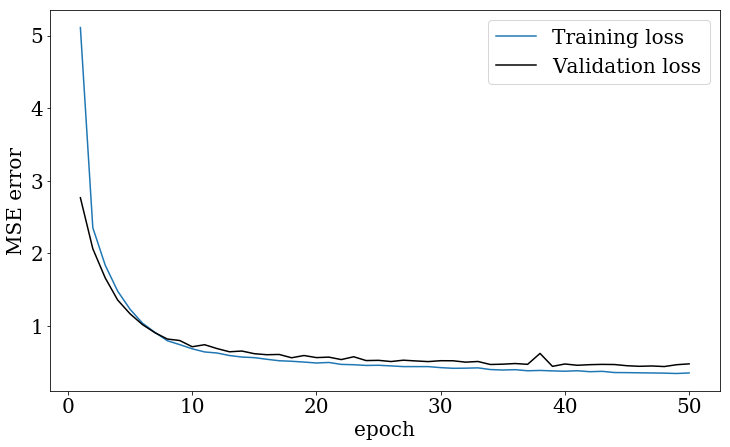

In [10]:
epoch = np.arange(1,epochs+1)
plt.figure(figsize=(12, 7))
plt.rc('font', family='serif')
plt.rc('font', size=20)

plt.plot(epoch,loss_train,label='Training loss')
plt.plot(epoch,loss_val,c='k',label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE error')
plt.legend()
plt.savefig(r'./figures/loss_coord.pdf', bbox_inches='tight')